In [1]:
from pathlib import Path

import pandas as pd
from tqdm import tqdm
from pathlib import Path
import os

datasetPath = os.path.abspath("dataset")
clothMaskPath = Path(datasetPath+'\with_cloth_mask')
surgicalMaskPath = Path(datasetPath+'\with_surgical_mask')
ffp2MaskPath = Path(datasetPath+'\with_ffp2_mask')
nonMaskPath = Path(datasetPath+'\without_mask')

maskDF = pd.DataFrame()

for imgPath in tqdm(list(nonMaskPath.iterdir()), desc='without_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 0
    }, ignore_index=True)

for imgPath in tqdm(list(surgicalMaskPath.iterdir()), desc='with_surgical_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 1
    }, ignore_index=True)

for imgPath in tqdm(list(clothMaskPath.iterdir()), desc='with_cloth_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 2
    }, ignore_index=True)

for imgPath in tqdm(list(ffp2MaskPath.iterdir()), desc='with_ffp2_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 3
    }, ignore_index=True)

dfName = 'dataset/dataset.pickle'
print(f'Saving Dataframe to: {dfName}')
maskDF.to_pickle(dfName)
maskDF

with_ffp2_mask: 100%|██████████| 486/486 [00:00<00:00, 515.24it/s]

Saving Dataframe to: dataset/dataset.pickle


,image,mask
0,C:\Users\rahul\dataset\without_mask\without_ma...,0.0
1,C:\Users\rahul\dataset\without_mask\without_ma...,0.0
2,C:\Users\rahul\dataset\without_mask\without_ma...,0.0
3,C:\Users\rahul\dataset\without_mask\without_ma...,0.0
4,C:\Users\rahul\dataset\without_mask\without_ma...,0.0
...,...,...
2347,C:\Users\rahul\dataset\with_ffp2_mask\with_ffp...,3.0
2348,C:\Users\rahul\dataset\with_ffp2_mask\with_ffp...,3.0
2349,C:\Users\rahul\dataset\with_ffp2_mask\with_ffp...,3.0
2350,C:\Users\rahul\dataset\with_ffp2_mask\with_ffp...,3.0


In [2]:
"""
The DataSet class
"""

from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize


class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.225, 0.225, 0.225]
                )
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)
    


In [3]:
"""
The CNN model
"""

import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU, Sequential, functional)

class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__()
        # Conv Layers : Conv2d
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) # 32 - 3 + 1 + 2*1 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1) # 32 - 3 + 1 + 2*1
        #fully Connected: Linear :: features
        # torch.nn.Linear(in_features, out_features, bias=True)
        # in_features – size of each input sample
        # out_features – size of each output sample
        batch_size = 3
        # Simulate a 32 x 32 pixel, rgb "image"
        ip = torch.randn(3, 32, 32)
        print(ip.view(batch_size, -1).size())
        self.fc1 = nn.Linear(8 * 8 * 8, 32)  # 8(out_channel :: prev) &&  8 * 8(computation from the forward max_pool2d * 2 with stride 2) 
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 4) # final feature labels as 4

    def forward(self, x: Tensor):
        """ forward pass 
        The forward() method is the actual network transformation. 
        The forward method is the mapping that maps an input tensor 
        to a prediction output tensor.
        # Convolution Operation
        """
        out = functional.max_pool2d(torch.tanh(self.conv1(x)), 2) # 32 -> 16
        out = functional.relu(out)
        out = functional.max_pool2d(torch.tanh(self.conv2(out)), 2) # 16 -> 8
        out = functional.relu(out)
        # flatten
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        # fc layer
        out = self.fc2(out)
        return out

face_mask_detector_cnn = FaceMaskDetectorCNN()
face_mask_detector_cnn = face_mask_detector_cnn.cuda()
face_mask_detector_cnn

torch.Size([3, 1024])


FaceMaskDetectorCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [4]:
"""
Print model summary
"""

from torchsummary import summary
print(summary(face_mask_detector_cnn,input_size=(3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2            [-1, 8, 16, 16]           1,160
            Linear-3                   [-1, 32]          16,416
            Linear-4                   [-1, 64]           2,112
Total params: 20,136
Trainable params: 20,136
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.08
Estimated Total Size (MB): 0.23
----------------------------------------------------------------
None


In [5]:
"""
Some utilities
"""

from pathlib import Path
from typing import Dict, List, Union

import pandas as pd
import torch
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU, Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt

def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        # print the distribution
        print(mask_df['mask'].value_counts())
        train, validate = train_test_split(mask_df, test_size=0.3, random_state=0,
                                           stratify=mask_df['mask'])
        return [
            MaskDetectionDataset(train),
            MaskDetectionDataset(validate),
            CrossEntropyLoss()
            ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)   

train_df, validate_df, cross_entropy_loss = prepare_data("dataset/dataset.pickle")

0.0    857
2.0    507
1.0    502
3.0    486
Name: mask, dtype: int64


In [6]:
epochs = 20
learning_rate = 0.001 
retrain = False
"""
Training Step
"""

import warnings
warnings.filterwarnings('ignore')

def train_model():
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_df), 0):
            inputs, labels = data['image'], data['mask']
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            loss_train += loss
        print(f' LOSS :: Training Loss (after epoch {epoch}):', loss_train)

train_model()
print('Model training has finished')

 LOSS :: Training Loss (after epoch 0): tensor(125.9685, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 1): tensor(75.0408, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 2): tensor(62.1901, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 3): tensor(52.6039, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 4): tensor(47.1179, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 5): tensor(42.2026, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 6): tensor(38.6544, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 7): tensor(35.3264, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 8): tensor(32.5122, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after epoch 9): tensor(30.9161, device='cuda:0', grad_fn=<AddBackward0>)
 LOSS :: Training Loss (after

                    precision    recall  f1-score   support

      without_mask       0.92      0.94      0.93       257
with_mask_surgical       0.84      0.84      0.84       151
   with_mask_cloth       0.70      0.80      0.75       152
    with_mask_ffp2       0.82      0.68      0.74       146

          accuracy                           0.83       706
         macro avg       0.82      0.81      0.82       706
      weighted avg       0.84      0.83      0.83       706

Confusion matrix, without normalization
[[242   1   7   7]
 [  6 127  15   3]
 [  7  13 121  11]
 [  7  11  29  99]]


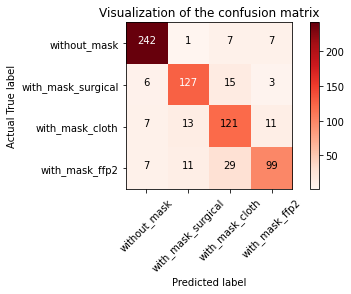

In [7]:
"""
Evaluate the model
"""

from numpy import vstack
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

def evaluate_model():
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_df)):
        inputs, targets = data['image'], data['mask']
        inputs = inputs.cuda()
        targets = targets.cuda()
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = predictions.cuda()
        actuals = actuals.cuda()
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)  
        
    #print metrics
    classes = ['without_mask','with_mask_surgical', 'with_mask_cloth', 'with_mask_ffp2']
    print(classification_report(actuals.cpu(), predictions.cpu(), digits = 2, target_names=classes))
    confusion_mat = confusion_matrix(actuals.cpu().numpy(), predictions.cpu().numpy())
    plot_cm(confusion_mat, classes)
evaluate_model()

C:\Users\rahul\dataset\with_cloth_mask\with_mask_2834.jpg
Actual: with_mask_cloth
Predicted: with_mask_cloth


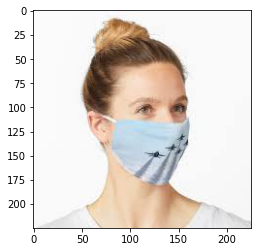

In [9]:
"""
Predict
"""

import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "with_mask_surgical",
    2: "with_mask_cloth",
    3: "with_mask_ffp2",
}

def predict():
    rand_sampler = torch.utils.data.RandomSampler(validate_df, num_samples=32, replacement=True)
    data = iter(DataLoader(validate_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    inputs = inputs.cuda()
    targets = targets.cuda()
    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    rand_ind = random.choice(list(range(0,32)))
    print(data['path'][rand_ind])
    img = Image.open(data['path'][rand_ind])
    plt.imshow(np.asarray(img))
    print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
    print("Predicted:",class_mapping[output[rand_ind].tolist()])
    
predict()